In [ ]:
import sys,warnings
sys.path.append('./DevEndo/') # change to the path where devendo.py stript located.
import devendo as de
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import anndata, re,os
from scipy.sparse import csr_matrix,csc_matrix, find
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
sc.settings.set_figure_params(dpi=100, facecolor='white')
pd.set_option("display.max_rows", 40)
pd.set_option("display.precision", 2)

## 1. Load datasets

### 1.1 STED-EC data

In [169]:
adata = sc.read_h5ad('DATA/sted-ec.h5ad')

In [172]:
casz1 = sc.read('DATA/Casz1_Final.h5ad')
casz1_endo = casz1[casz1.obs['maincelltype'] == 'Endothelial cells']
casz1_ctrl = casz1_endo[casz1_endo.obs['condition'] == 'Ctrl']
casz1_cko = casz1_endo[casz1_endo.obs['condition'] == 'CKO']
casz1_ctrl.obs['Organ'] = "Casz1_ctrl"
casz1_cko.obs['Organ'] = "Casz1_cko"

In [173]:
public_data['Casz1_ctrl'] = casz1_ctrl
public_data['Casz1_cko'] = casz1_cko

### 1.2 Public organtypic EC data

In [170]:
Manno2021 = sc.read('DATA/public_datasets/Manno2021_Brain_Endo.h5ad')
Feng2022 = sc.read('DATA/public_datasets/Feng2022_Heart_Endo.h5ad')
Zepp2021 = sc.read('DATA/public_datasets/Zepp2021_Lung_Endo.h5ad')
Kalucka2020 = sc.read('DATA/public_datasets/Kalucka2020.h5ad');gi = Kalucka2020[Kalucka2020.obs['organ'] == 'Intestine'];lymph = Kalucka2020[Kalucka2020.obs['organ'] == 'Lymph'];muscle = Kalucka2020[Kalucka2020.obs['organ'] == 'Muscle']
Salinero2022 = sc.read('DATA/public_datasets/Salinero2022_Liver_Endo.h5ad')
Magella2018 = sc.read('DATA/public_datasets/Magella2018_Kidney_Endo.h5ad')
Combes2019 = sc.read('DATA/public_datasets/Combes2019_Kidney_Endo.h5ad')
# renal = Magella2018.concatenate(Combes2019)
Zhao2022 = sc.read('DATA/public_datasets/Zhao2022_Gastrointestinal_tract_Endo.h5ad')
liu2022 = sc.read('DATA/public_datasets/Liu2022_Bone_Marrow_Endo.h5ad')
Manno2021 = Manno2021[Manno2021.obs['stage'].isin(['E15.0', 'E15.5', 'E16.0', 'E16.5', 'E16.25','E17.0', 'E17.5', 'E18.0'])]
Zhao2022 = Zhao2022[Zhao2022.obs['stage'].isin([ 'E13.5', 'E15.5'])]
Salinero2022 = Salinero2022[Salinero2022.obs['stage'].isin(['E16', 'E18'])]
Zepp2021 = Zepp2021[Zepp2021.obs['stage'].isin(['E17.5'])]

In [171]:
public_data = {'CNS ECs':Manno2021,'Endocardial ECs':Feng2022,'Pulmonary ECs':Zepp2021,
               'Lymphatic ECs':lymph, 'Hepatic ECs':Salinero2022, 'Renal ECs':Combes2019,
               'Gastrointestinal ECs':gi,'Bone marrow ECs':liu2022,'Muscle&skin':muscle} 
for x in public_data:
    public_data[x].obs['Organ'] = x

In [174]:
bdata = anndata.concat([public_data[i] for i in public_data])

In [175]:
deg = de.FindAllMarkers(adata, 'label')

Calculate DEGs...


In [176]:
features = np.unique(deg['names'])

## 2. Mapping the cells to EC atlas

We first performed PCA and Harmony to integrate the STED-EC dataset with public datasets, and subsequently assigned the layout of STED-ECs to endothelial cells (ECs) from each organ via the 1-nearest neighbor.

Runing PCA...


2025-07-07 04:27:27,695 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2025-07-07 04:29:24,195 - harmonypy - INFO - sklearn.KMeans initialization complete.
2025-07-07 04:29:25,721 - harmonypy - INFO - Iteration 1 of 10
2025-07-07 04:33:51,693 - harmonypy - INFO - Iteration 2 of 10
2025-07-07 04:38:11,495 - harmonypy - INFO - Iteration 3 of 10
2025-07-07 04:42:31,480 - harmonypy - INFO - Iteration 4 of 10
2025-07-07 04:46:59,803 - harmonypy - INFO - Iteration 5 of 10
2025-07-07 04:51:19,108 - harmonypy - INFO - Iteration 6 of 10
2025-07-07 04:55:44,896 - harmonypy - INFO - Iteration 7 of 10
2025-07-07 05:00:08,885 - harmonypy - INFO - Iteration 8 of 10
2025-07-07 05:04:37,593 - harmonypy - INFO - Converged after 8 iterations


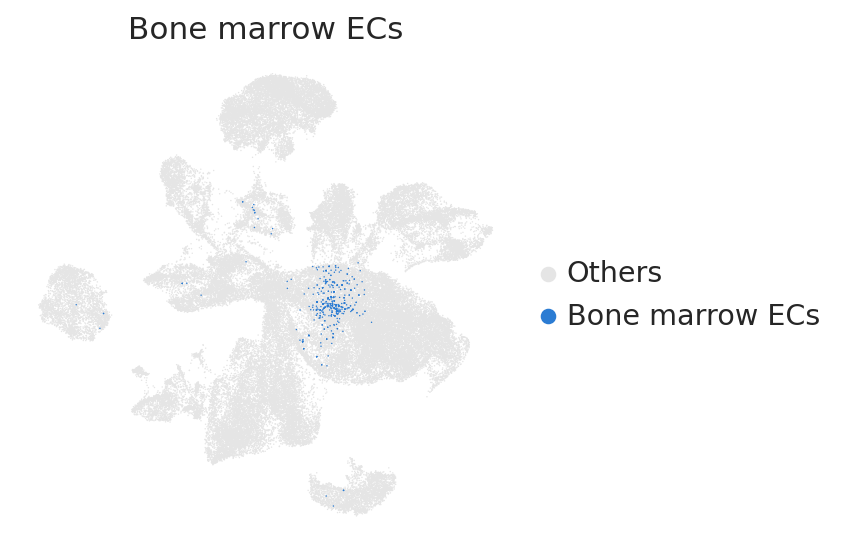

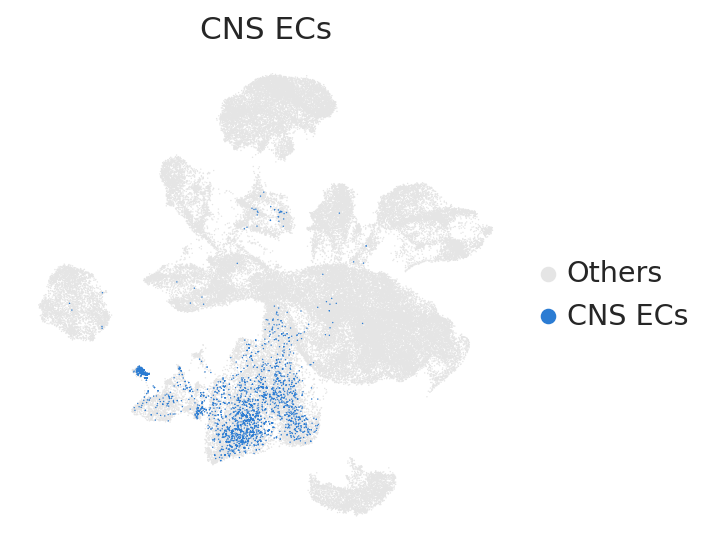

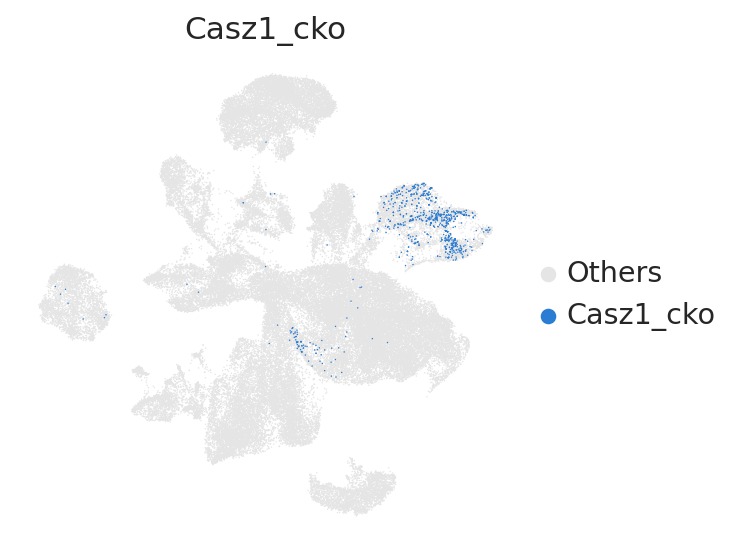

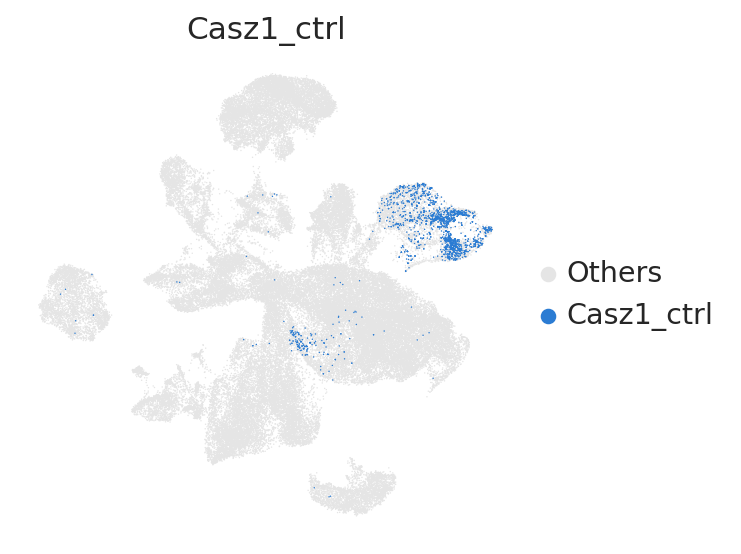

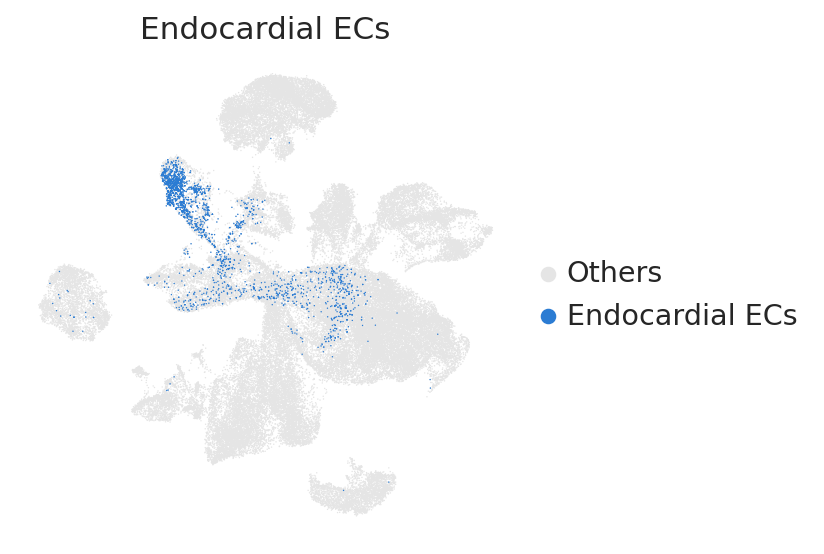

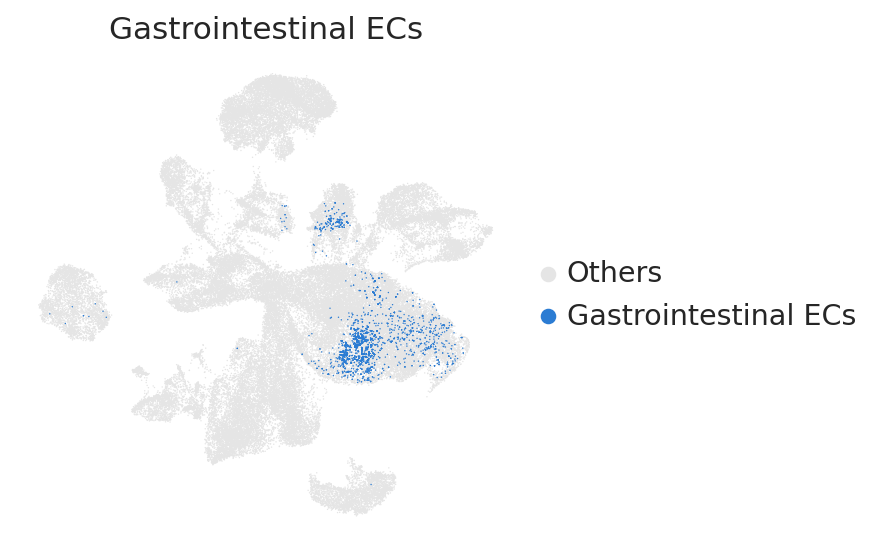

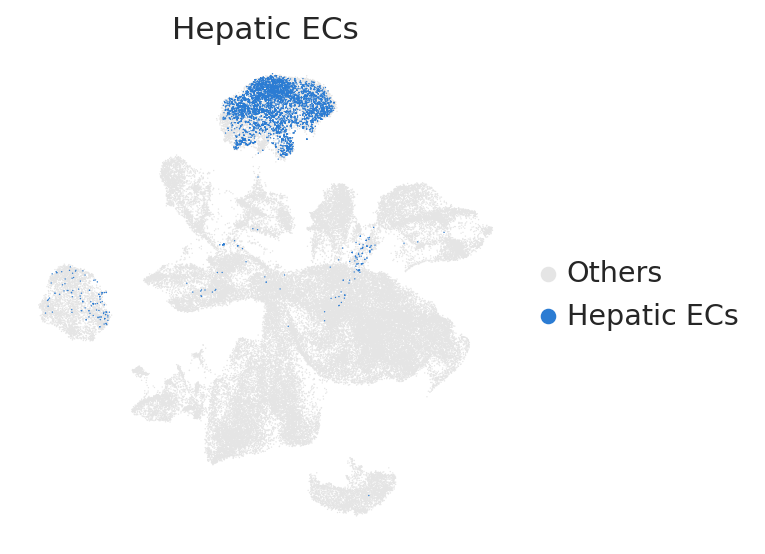

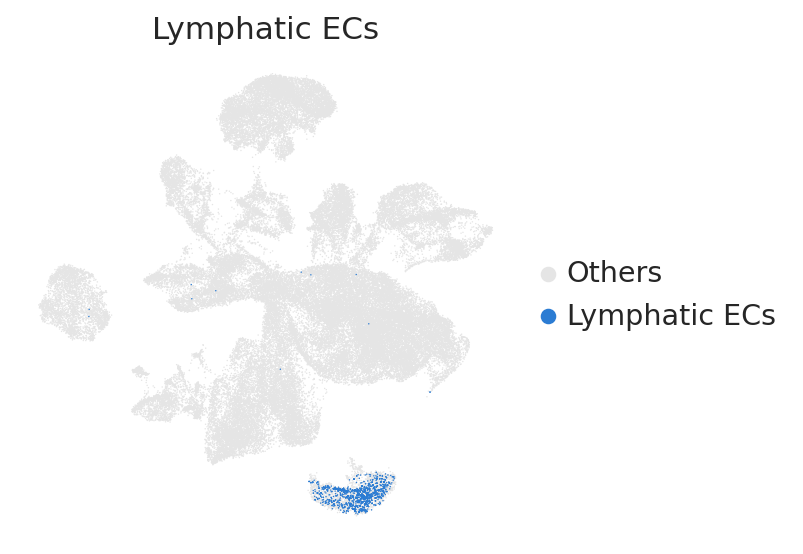

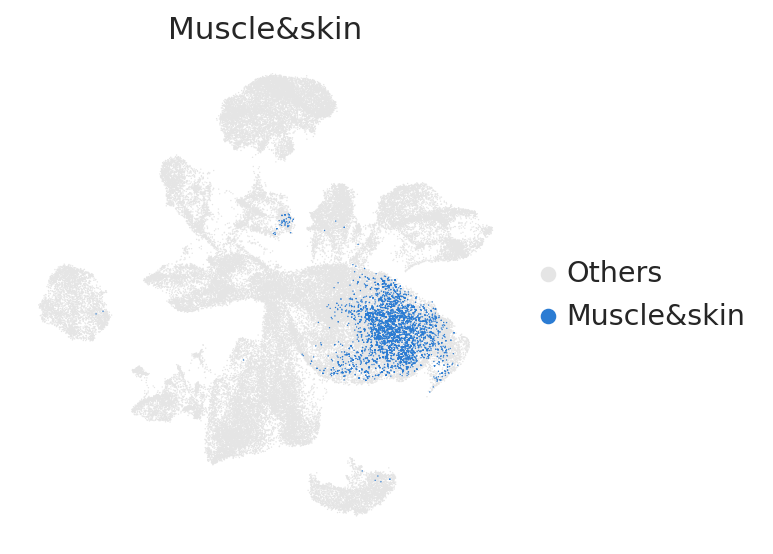

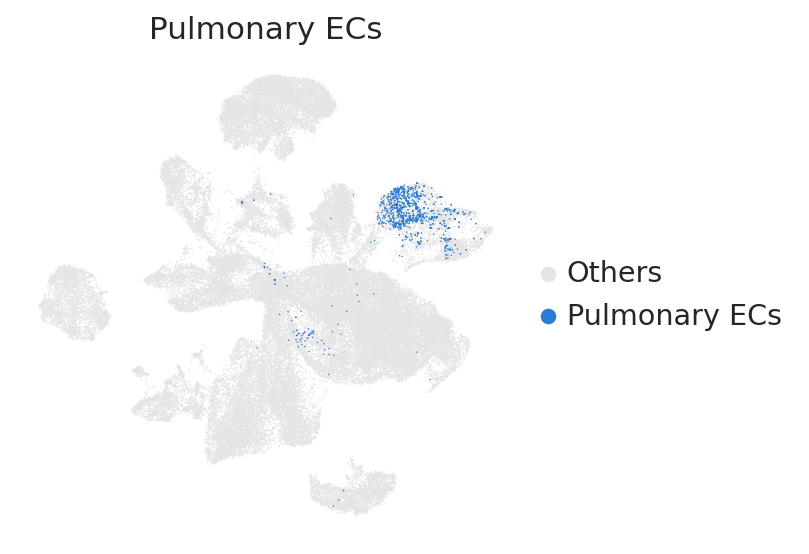

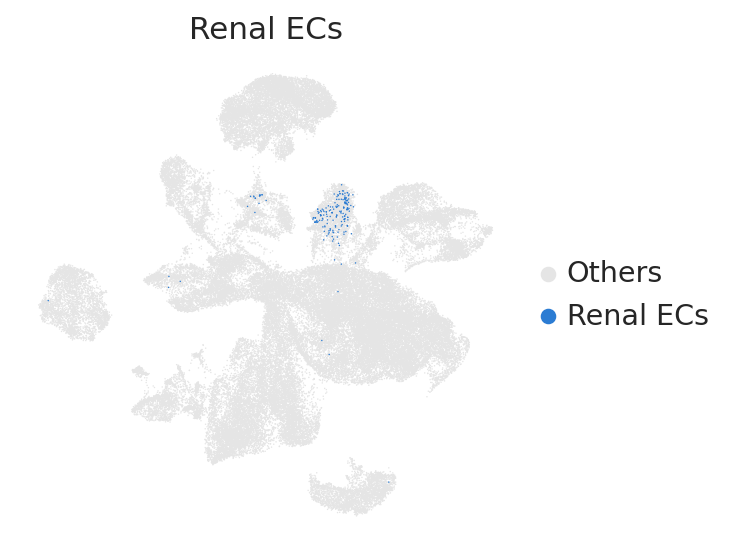

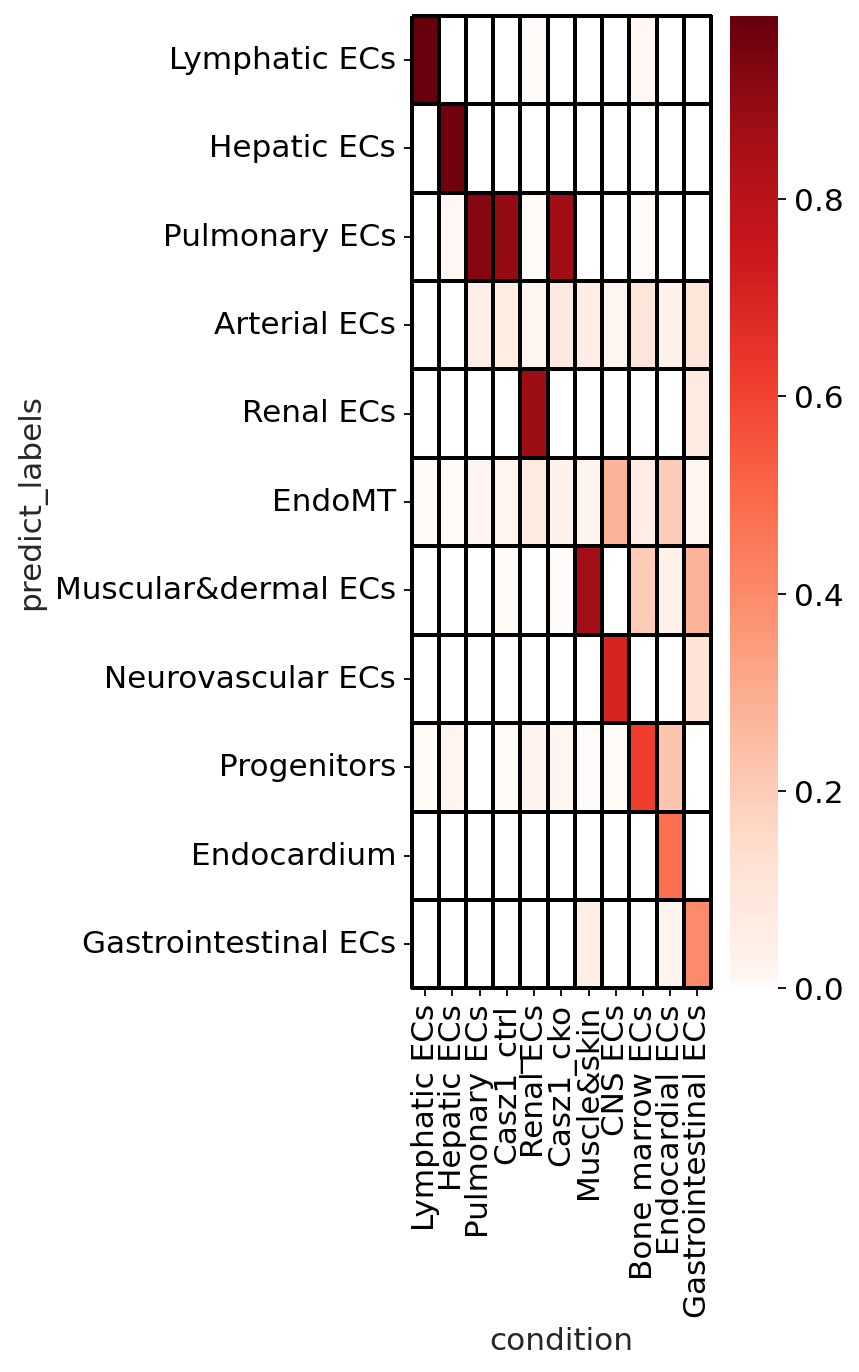

In [178]:
mdata = de.fateMapping(adata, bdata,predict_labels='label',features=features, n_components=30,condition = 'Organ',runcca=False,save=True,plot_mapping_layout=True,plot_mapping_ratio=True)

In [179]:
stack_ratio = mdata.uns['mapping_ratio']

In [181]:
color_dict = dict(zip(adata.obs['label'].cat.categories.tolist(), adata.uns['label_colors']))

In [182]:
stack_ratio = stack_ratio[~stack_ratio.index.isin(['Progenitors','EndoMT'])]
stack_ratio.rename(columns = {'Lymphatic ECs':'Kalucka2020_Lymph', 'Hepatic ECs':'Salinero2022_Liver','Renal ECs':'Combes2019_Kidney',
                              'Pulmonary ECs':'Zepp2021_Lung','Casz1_ctrl':'E18.5 Casz1-Ctrl_Lung','Casz1_cko':'E18.5 Casz1-CKO_Lung','CNS ECs':'Manno2021_Brain','Gastrointestinal ECs':'Kalucka2020_Intestine',
                              'Endocardial ECs':'Feng2022_Heart','Muscle&skin':'Kalucka2020_Muscle'},inplace=True)
stack_ratio = stack_ratio.loc[['Neurovascular ECs',  'Lymphatic ECs', 'Endocardium', 'Hepatic ECs', 'Gastrointestinal ECs', 'Renal ECs','Muscular&dermal ECs','Pulmonary ECs','Arterial ECs'],
                              ['Manno2021_Brain','Kalucka2020_Lymph', 'Feng2022_Heart', 'Salinero2022_Liver', 'Kalucka2020_Intestine', 'Combes2019_Kidney','Kalucka2020_Muscle','Zepp2021_Lung', 'E18.5 Casz1-Ctrl_Lung','E18.5 Casz1-CKO_Lung']]

In [183]:
stack_ratio_public = stack_ratio.iloc[:,:-2]
stack_ratio_casz1 = stack_ratio.iloc[:,-2:]

In [184]:
stack_ratio_public = stack_ratio_public / stack_ratio_public.sum(axis=0)  # axis=0 表示按列计算总和
stack_ratio_casz1 = stack_ratio_casz1 / stack_ratio_casz1.sum(axis=0)  # axis=0 表示按列计算总和

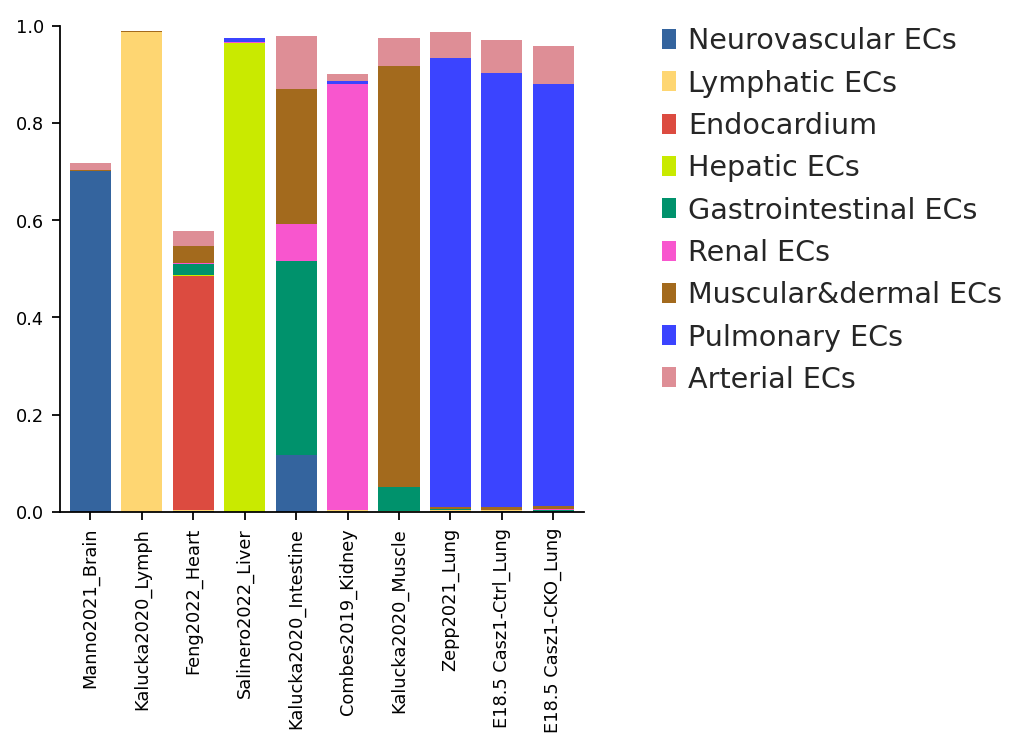

In [185]:
legend_ncol = 1
# first_time = stack_ratio.apply(lambda x:min(np.where(x>max(x)*0.01)[0]),axis = 1).values # 根据首次出现的时间排序
# max_ratio = stack_ratio.apply(max,axis = 1).values # 根据占比排序
# _, _, new_index = zip(*sorted(zip(first_time, max_ratio, stack_ratio.index.values)))

# stack_ratio = stack_ratio.loc[new_index[::-1],:]

labels= stack_ratio.index.values
fig, ax = plt.subplots(figsize = (4.2,4))
for i in range(stack_ratio.shape[0]):
    ax.bar(stack_ratio.columns.values,
           stack_ratio.iloc[i,:].values, label=labels[i],
           color = color_dict[labels[i]],
           bottom=stack_ratio.iloc[:i,:].sum(0).values,
           linewidth = 0,
           width = 0.8)
ax.grid(False)
ax.margins(x=0.02)
for label in ax.get_xticklabels():
    label.set_ha("center")
    label.set_rotation(90)
    label.set_fontsize(8)
for label in ax.get_yticklabels():
    label.set_fontsize(8) 
ax.legend(bbox_to_anchor=(1.1, 1.05),ncol=legend_ncol, frameon=False)
ax.set_ylim(0,1)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.tick_params(axis='x', which='both', bottom=True, top=False,left=False, labelleft=True)
ax.tick_params(axis='y', which='both', bottom=False, top=False,left=True, labelleft=True)
plt.savefig('figures/R1Q14_标准化后的器官映射分数柱状图.pdf')

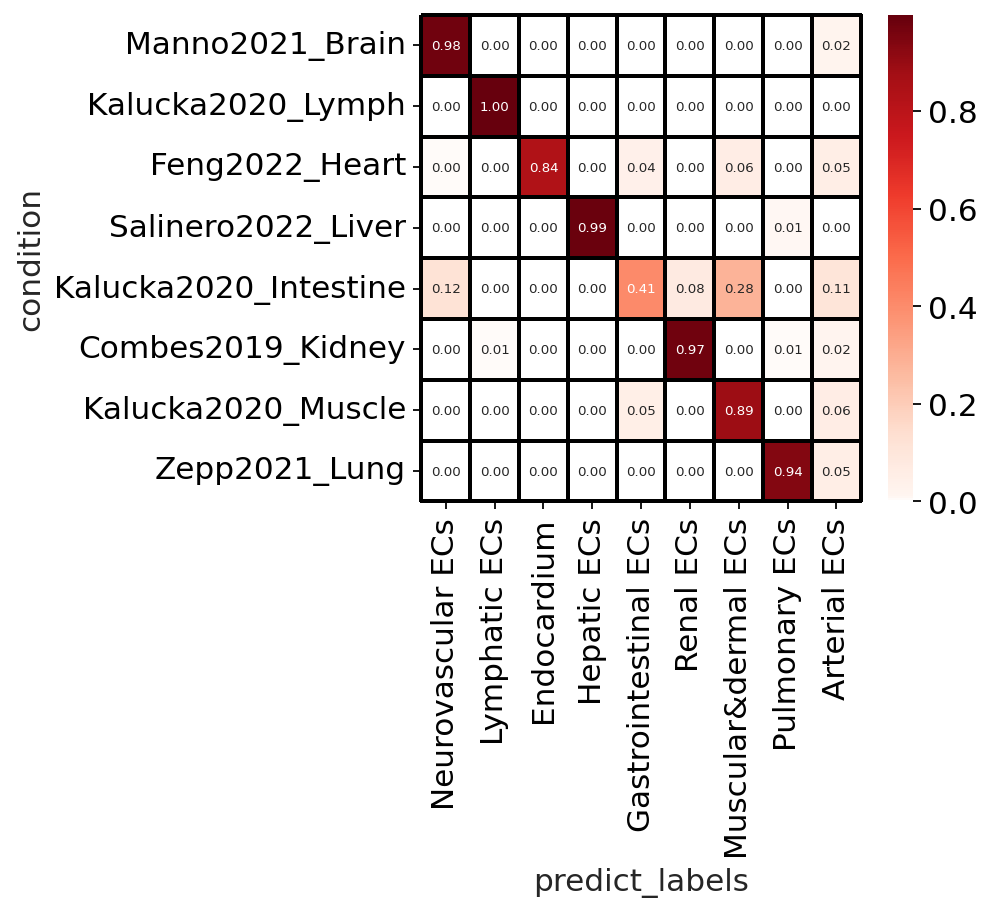

In [186]:
fig, ax = plt.subplots(figsize=(4.4,4))
sns.heatmap(stack_ratio_public.T, cmap = de.mymap_wr, annot=True, fmt=".2f",annot_kws={'size': 6},xticklabels=True, yticklabels=True,linewidths=1, linecolor='black', clip_on=False,ax=ax)

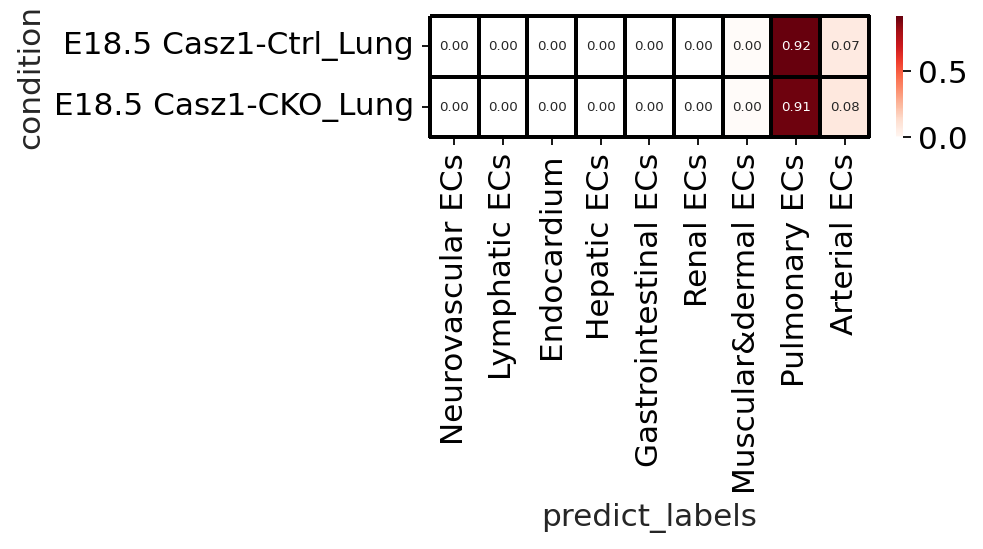

In [187]:
fig, ax = plt.subplots(figsize=(4.4,1.))
sns.heatmap(stack_ratio_casz1.T, cmap = de.mymap_wr, annot=True, fmt=".2f",annot_kws={'size': 6},xticklabels=True, yticklabels=True,linewidths=1, linecolor='black', clip_on=False,ax=ax)

## 3. Test the importance of cell type markers

In [192]:
organ_ec_markers = {
    'CNS':['Foxq1','Pglyrp1'],
    'Endocardial':['Hand2','Tmem108'],
    'Pulmonary':['Scn7a','Tmem100'],
    'Lymphatic':['Prox1','Reln'],
    'Hepatic':['Dnase1l3','Oit3'],
    'Renal':['Irx3','Ptpru'],
    'Muscular&dermal':['C1qtnf9','Timp4'],
    'Gastrointestinal':['Madcam1','Nkx2−3'],
    'EndoMT':['Pdgfra','Pdgfrb', 'Acta2']
}

### 3.1 Train random forest classifier using full genes

In [193]:
n_estimators = 500
max_depth = 30

In [152]:
np.random.seed(1)
train_ids =np.random.choice(np.arange(adata.shape[0]), round(adata.shape[0]*0.9),replace=False)

In [153]:
data_train = adata[train_ids]
data_test = adata[~adata.obs_names.isin(data_train.obs_names)]

In [155]:
sc.pp.highly_variable_genes(data_train, min_mean=0.0125, max_mean=3, min_disp=0.5)
hvg = data_train.var_names.values[data_train.var['highly_variable'].values]

In [156]:
deg = de.FindAllMarkers(data_train, 'label')

Calculate DEGs...


In [157]:
used_genes = np.unique(np.concatenate([hvg, deg['names'].values]))
# used_genes = np.unique(deg['names'].values)
used_genes = [item for item in used_genes if not item.startswith("mt-")]
used_genes = [item for item in used_genes if not item.startswith("AC")]

In [158]:
label,model = de.predict_cell_labels(data_train, data_test, training_label='label',
                                      features=used_genes, predict_label='predict_label',cells_per_group = 1000,
                                      n_estimators = n_estimators,max_depth=max_depth,
                                      return_model = True) # X_pca

Results are save in .obs['predict_label'] and predict_adata.uns['predict_proba']


In [159]:
true_label = data_test.obs['label'].values
pred_label = data_test.obs['predict_label'].values # label

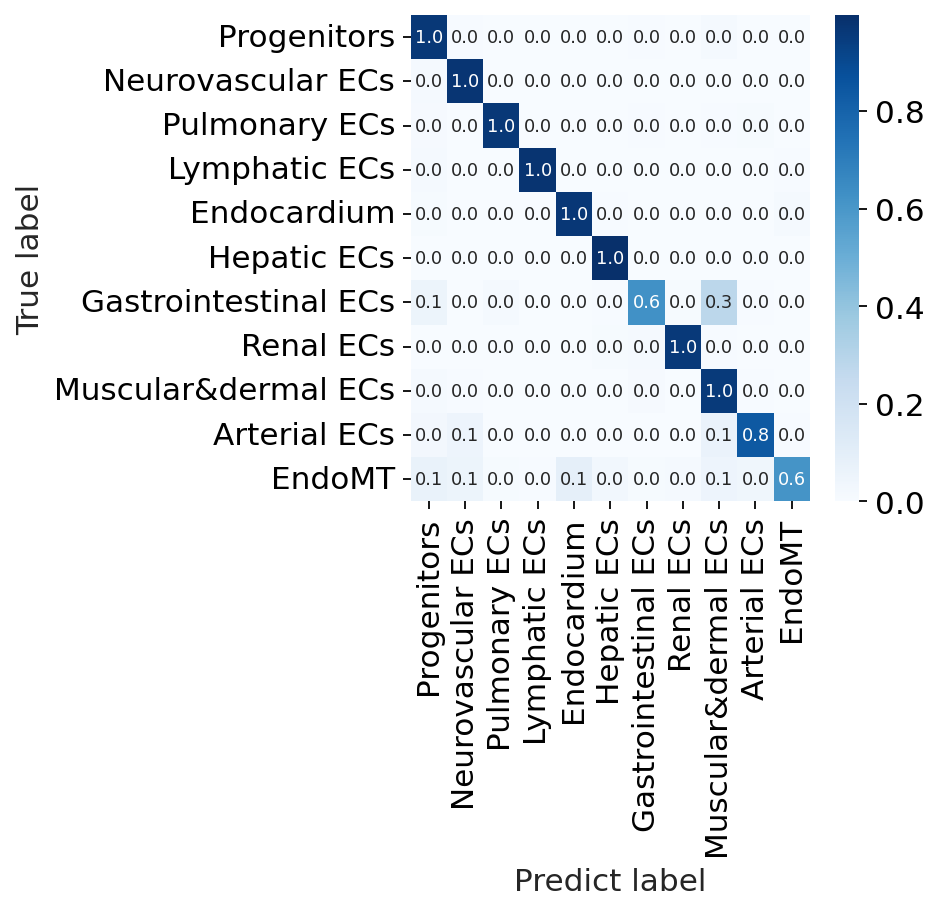

<Figure size 320x320 with 0 Axes>

In [160]:
# 计算混淆矩阵
cm = confusion_matrix(true_label, pred_label,labels = data_test.obs['label_2024'].cat.categories.tolist(),normalize='true')
cm = pd.DataFrame(cm, index = data_test.obs['label_2024'].cat.categories.tolist(), columns = data_test.obs['label_2024'].cat.categories.tolist())
sns.heatmap(cm, annot=True,fmt = '.1f', cmap='Blues',annot_kws={'size': 8})
plt.xlabel('Predict label')
plt.ylabel('True label')

### 3.2 Random forest prediction after excluding 2 marker genes.

In [209]:
rm_genes = np.concatenate([organ_ec_markers[x] for x in organ_ec_markers])

In [210]:
label1 = de.predict_cell_labels(data_train, data_test[:,~data_test.var_names.isin(rm_genes)], training_label='label',model=model,
                                      features=used_genes, predict_label='predict_label',cells_per_group = 1000,
                                      n_estimators = n_estimators,max_depth=max_depth,
                                      return_model = False) # X_pca

Results are save in .obs['predict_label'] and predict_adata.uns['predict_proba']


In [211]:
true_label = data_test.obs['label'].values
pred_label = label1

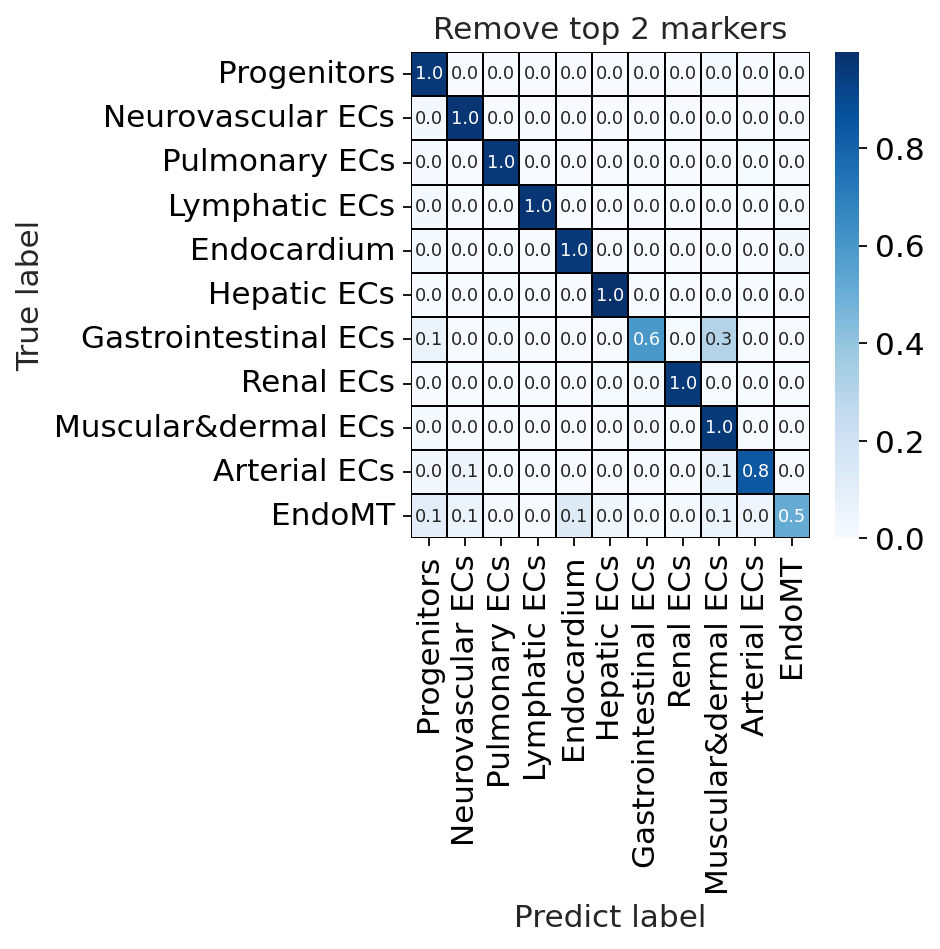

In [212]:
# Confusion matrix
cm = confusion_matrix(true_label, pred_label,labels = data_test.obs['label'].cat.categories.tolist(),normalize='true')
cm = pd.DataFrame(cm, index = data_test.obs['label'].cat.categories.tolist(), columns = data_test.obs['label'].cat.categories.tolist())
sns.heatmap(cm, annot=True,fmt = '.1f', cmap='Blues',annot_kws={'size': 8},    linewidths=0.8,linecolor="black")
plt.title('Remove top 2 markers')
plt.xlabel('Predict label')
plt.ylabel('True label')

### 3.3 Random forest prediction after excluding 15 marker genes.

In [204]:
top_15_degs = pd.read_csv('DATA/R1Q2_Top15_marker_score_states.csv',index_col = 0)

In [205]:
label2 = de.predict_cell_labels(data_train, data_test[:,~data_test.var_names.isin(top_15_degs['names'])], training_label='label',model=model,
                                      features=used_genes, predict_label='predict_label',cells_per_group = 1000,
                                      n_estimators = n_estimators,max_depth=max_depth,
                                      return_model = False) # X_pca

Results are save in .obs['predict_label'] and predict_adata.uns['predict_proba']


In [206]:
true_label = data_test.obs['label'].values
pred_label = label2

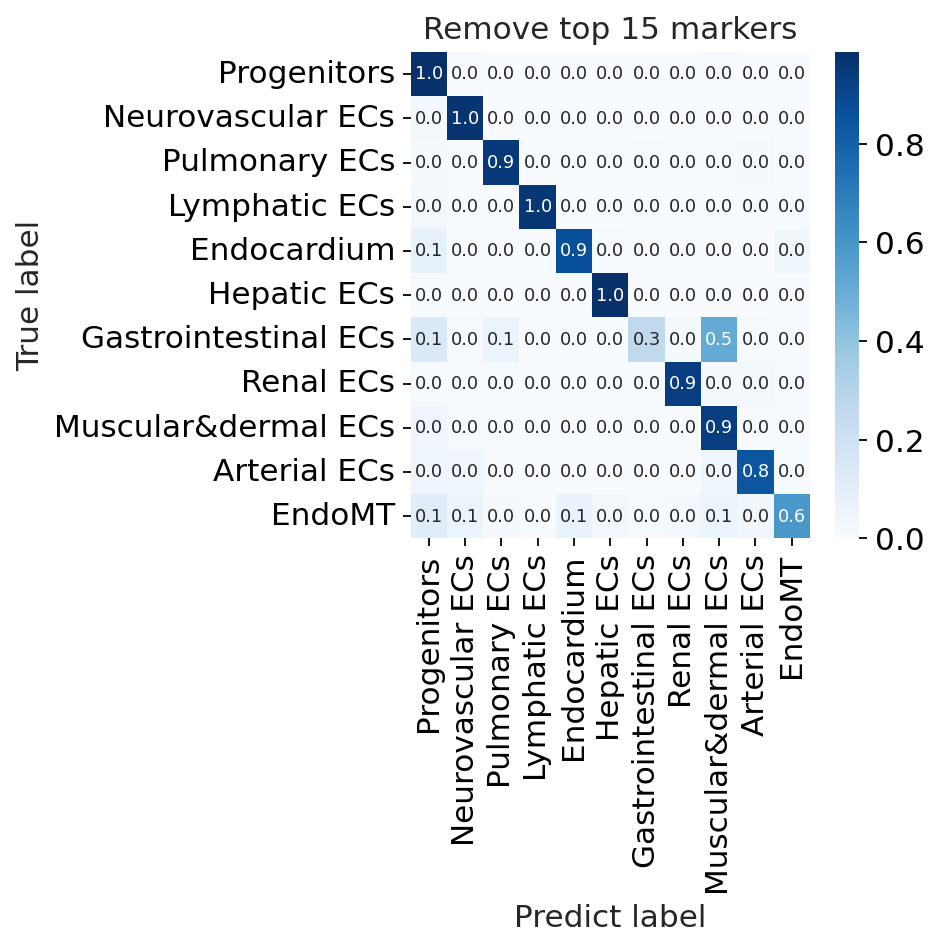

In [207]:
# Confusion matrix
cm = confusion_matrix(true_label, pred_label,labels = data_test.obs['label_2024'].cat.categories.tolist(),normalize='true')
cm = pd.DataFrame(cm, index = data_test.obs['label'].cat.categories.tolist(), columns = data_test.obs['label'].cat.categories.tolist())
sns.heatmap(cm, annot=True,fmt = '.1f', cmap='Blues',annot_kws={'size': 8})
plt.title('Remove top 15 markers')
plt.xlabel('Predict label')
plt.ylabel('True label')